# Degradation example


This juypter notebook is intended to test the degradation analysis workflow.  In addition, the notebook demonstrates the effects of changes in the workflow.

Degradation analysis of PV systems includes several steps:
1. <b>Standardize</b> data inputs
2. <b>Normalize</b> data using a performance metric
3. <b>Filter</b> data that creates bias 
4. <b>Analyze</b> aggregated data to estimate the degradation rate



In [1]:
# Enable inline plotting
%matplotlib inline

# Backport python3 division behavior
from __future__ import division

from urllib import urlencode
import datetime
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import os

import pytz
from pprint import pprint

from sklearn.linear_model import LinearRegression
import seaborn as sns

# Set plotting configuration
sns.set_palette('deep', desat=.8)
sns.set_context('notebook', font_scale=1.5, rc={'figure.figsize': (16,5)})
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)

import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

In [2]:
import pvlib
import rdtools

print pvlib.__version__
print rdtools.__version__

/Users/anag/anaconda/envs/python2.7/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


0.4.5
1.0.1+31.gc86550c.dirty


# 1. <b>Standardize</b>

Please download the annual csv data for system with system id 4, using the PVDAQ API, and store the csv file in the folder:
./rdtools/docs/

https://developer.nrel.gov/docs/solar/pvdaq-v3/data_file/

The following script loads the data, parses a pandas.DateTimeIndex, and renames the critical pandas.Series objects.



In [3]:
systemid=4
api_key='ZRHhZvBE4s40rAkPi1A1jyyjOA4KIF5ULinBPmEd'
pvdaq_metadata_url = 'http://developer.nrel.gov/api/pvdaq/v3/sites.xml?system_id=' + str(systemid) + '&api_key=' + api_key

In [4]:
pvdaq_metadata_url

'http://developer.nrel.gov/api/pvdaq/v3/sites.xml?system_id=4&api_key=ZRHhZvBE4s40rAkPi1A1jyyjOA4KIF5ULinBPmEd'

In [5]:
import urllib2
import xmltodict
import xml.etree.ElementTree as et

file = urllib2.urlopen(pvdaq_metadata_url)
tree = et.parse(file)
file.close()

root = tree.getroot()



avail_year = [int(avail_year.text) for avail_year in root.iter('available-year')]
start_year = avail_year[0]
end_year = avail_year[-1]
inverter_mfg = [str(inv_mfg.text) for inv_mfg in root.iter('inverter-mfg')][0]
inverter_model = [str(inv_model.text) for inv_model in root.iter('inverter-model')][0]
module_mfg = [str(mod_mfg.text) for mod_mfg in root.iter('module-mfg')][0]
module_model = [str(mod_model.text) for mod_model in root.iter('module-model')][0]
power = [float(site_power.text) for site_power in root.iter('site-power')][0]
area = [float(site_area.text) for site_area in root.iter('site-area')][0]
azimuth = [float(site_azimuth.text) for site_azimuth in root.iter('site-azimuth')][0]
elevation = [float(site_elevation.text) for site_elevation in root.iter('site-elevation')][0]
lat = [float(site_lat.text) for site_lat in root.iter('site-latitude')][0]
lon = [float(site_lon.text) for site_lon in root.iter('site-longitude')][0]
lon = -lon
tilt = [float(site_tilt.text) for site_tilt in root.iter('site-tilt')][0]
name = [str(name_priv.text) for name_priv in root.iter('name-private')][0]

In [6]:
avail_year

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [7]:
year = 2012
pvdaq_ann_csv_url = 'http://developer.nrel.gov/api/pvdaq/v3/data_file.csv?api_key=' + api_key + '&system_id=' + str(systemid)+ '&year=' + str(year)

In [8]:
pvdaq_ann_csv_url

'http://developer.nrel.gov/api/pvdaq/v3/data_file.csv?api_key=ZRHhZvBE4s40rAkPi1A1jyyjOA4KIF5ULinBPmEd&system_id=4&year=2012'

In [9]:
df = pd.DataFrame()
list_years = avail_year
#list_years = [2011,2012,2013,2014]
for year in list_years:
    pvdaq_ann_csv_url = 'http://developer.nrel.gov/api/pvdaq/v3/data_file.csv?api_key=' + api_key + '&system_id=' + str(systemid)+ '&year=' + str(year)
    data = pd.read_csv(pvdaq_ann_csv_url)
    df = df.append(data)
    

In [10]:
df.head()

,SiteID,Date-Time,ac_current,ac_power,ac_voltage,ambient_temp,das_battery_voltage,das_temp,dc_pos_current,dc_pos_voltage,dc_power,inverter_temp,module_temp_1,module_temp_2,module_temp_3,poa_irradiance,power_factor
0,4,2007-08-26 00:00:00,-0.106,-0.006,118.753,22.395,NaN,23.670,0.008,0.472,0.004,NaN,21.588,NaN,NaN,14.0,NaN
1,4,2007-08-26 00:15:00,-0.108,-0.029,118.689,22.606,NaN,23.518,0.008,0.516,0.004,NaN,21.972,NaN,NaN,13.0,NaN
2,4,2007-08-26 00:30:00,-0.106,-0.029,118.737,22.939,NaN,23.502,0.008,0.476,0.004,NaN,21.920,NaN,NaN,13.0,NaN
3,4,2007-08-26 00:45:00,-0.105,-0.020,119.011,23.013,NaN,23.638,0.008,0.523,0.004,NaN,22.013,NaN,NaN,12.0,NaN
4,4,2007-08-26 01:00:00,-0.106,-0.021,118.950,22.614,NaN,23.677,0.008,0.486,0.004,NaN,21.414,NaN,NaN,13.0,NaN


In [11]:
type(df['Date-Time'])

pandas.core.series.Series

In [12]:
df['Date-Time'] = pd.to_datetime(df['Date-Time'])

In [13]:
df.set_index('Date-Time', inplace=True)

In [14]:
df.index

DatetimeIndex(['2007-08-26 00:00:00', '2007-08-26 00:15:00',
               '2007-08-26 00:30:00', '2007-08-26 00:45:00',
               '2007-08-26 01:00:00', '2007-08-26 01:15:00',
               '2007-08-26 01:30:00', '2007-08-26 01:45:00',
               '2007-08-26 02:00:00', '2007-08-26 02:15:00',
               ...
               '2017-07-03 20:21:00', '2017-07-03 20:22:00',
               '2017-07-03 20:23:00', '2017-07-03 20:24:00',
               '2017-07-03 20:25:00', '2017-07-03 20:26:00',
               '2017-07-03 20:27:00', '2017-07-03 20:28:00',
               '2017-07-03 20:29:00', '2017-07-03 20:30:00'],
              dtype='datetime64[ns]', name=u'Date-Time', length=3767092, freq=None)

In [15]:
df = df.resample('T').mean()

In [16]:
print pd.infer_freq(df.index)

T


In [17]:
timezone = pytz.timezone("Etc/GMT+7")
df.index = df.index.tz_localize(timezone)

In [18]:
module_temp = df.filter(regex=("module_temp*"))
module_temp = module_temp.median(axis=1)
df['module_temperature'] = module_temp

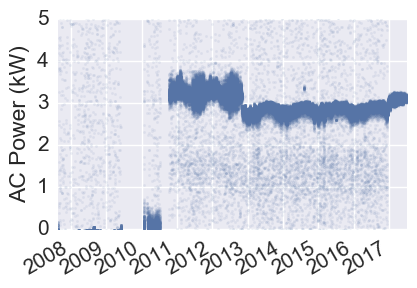

In [19]:
# downsample
df = df.asfreq('15T') 

# plot the AC power time series
fig, ax = plt.subplots()
ax.plot(df.index, df.ac_power, 'o', alpha = 0.1)
ax.set_ylim(0,5)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (kW)');

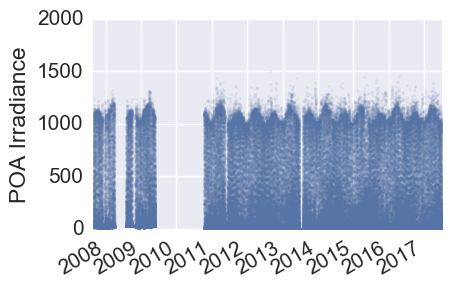

In [20]:
# plot the POA irradiance time series
fig, ax = plt.subplots()
ax.plot(df.index, df.poa_irradiance, 'o', alpha = 0.1)
ax.set_ylim(0,2000)
fig.autofmt_xdate()
ax.set_ylabel('POA Irradiance');

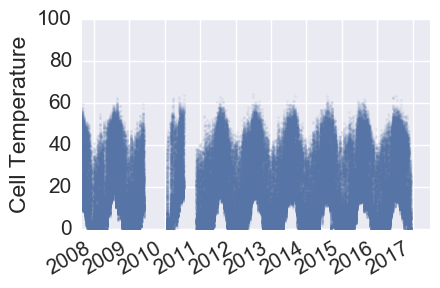

In [21]:
# plot the cell temperature time series
fig, ax = plt.subplots()
ax.plot(df.index, df.module_temperature, 'o', alpha = 0.1)
ax.set_ylim(0,100)
fig.autofmt_xdate()
ax.set_ylabel('Cell Temperature');

# 2. <b>Normalize</b> 

Data normalization typically requires some additional metadata about the PV system power time series.  Metadata consists of site location information, module product details, PV circuit configuration, and other items.

<15 * Minutes>


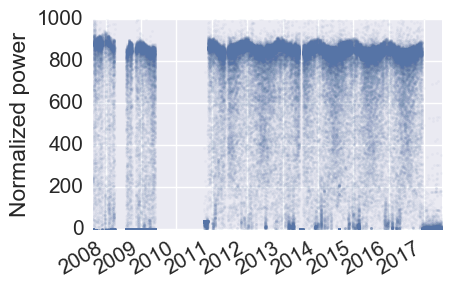

In [22]:
# Metadata
pdc = 1.0 # System size in kW

pvwatts_kws = {"poa_global" : df.poa_irradiance,
              "P_ref" : pdc,
              "T_cell" : df.module_temperature,
              "G_ref" : 1000,
              "T_ref" : 20,
              "gamma_pdc" : -0.0029}

normalized = rdtools.normalize_with_pvwatts(df.ac_power, pvwatts_kws)


# Plot the normalized power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,1000)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

In [23]:
normalized.head(n=50)

Date-Time
2007-08-26 00:00:00-07:00      -0.430554
2007-08-26 00:15:00-07:00      -2.243600
2007-08-26 00:30:00-07:00      -2.243260
2007-08-26 00:45:00-07:00      -1.676453
2007-08-26 01:00:00-07:00      -1.622036
2007-08-26 01:15:00-07:00      -2.467026
2007-08-26 01:30:00-07:00      -2.389980
2007-08-26 01:45:00-07:00      -2.677413
2007-08-26 02:00:00-07:00      -2.090955
2007-08-26 02:15:00-07:00      -2.504918
2007-08-26 02:30:00-07:00      -2.235879
2007-08-26 02:45:00-07:00      -2.156573
2007-08-26 03:00:00-07:00      -2.465206
2007-08-26 03:15:00-07:00      -2.502024
2007-08-26 03:30:00-07:00      -1.385427
2007-08-26 03:45:00-07:00      -1.644999
2007-08-26 04:00:00-07:00      -2.387142
2007-08-26 04:15:00-07:00      -2.669128
2007-08-26 04:30:00-07:00      -2.462295
2007-08-26 04:45:00-07:00      -2.664156
2007-08-26 05:00:00-07:00      -2.305012
2007-08-26 05:15:00-07:00      -1.998146
2007-08-26 05:30:00-07:00      -1.110448
2007-08-26 05:45:00-07:00      -0.515869
2007-0

# 3. <b>Filter</b> 

Data filtering is used to exclude data points that represent invalid data, create bias in the analysis, or introduce significant noise.


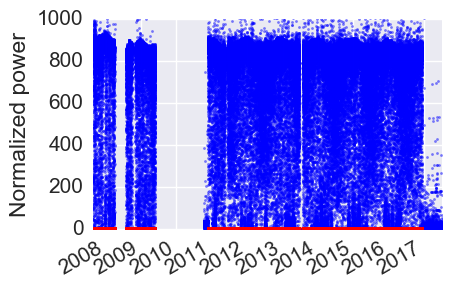

In [24]:
# Perform rudimetary filtering, more advanced filtering will be integrated
# into Rdtools in the future

df['normalized'] = normalized
#filter_criteria = ((df['normalized']>0) & (df['normalized']<2) & (df.poa_irradiance>200))
filter_criteria = ((df['normalized']>750) & (df['normalized']<1000) & (df.poa_irradiance>200))

filtered = df[filter_criteria]['normalized']




#after filtering, center the data at PR_t0 = 1
def center_data(series):
    v = series.resample('12M').median().max()    
    return series / v

filtered = center_data(filtered)


# Plot the normalized and filtered power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', color='b', alpha = 0.5)
ax.plot(filtered.index, filtered, 'o', color='r', alpha = 0.5)
ax.set_ylim(0,1000)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

In [25]:
filtered

Date-Time
2007-08-28 13:00:00-07:00    0.983179
2007-08-28 13:15:00-07:00    0.953189
2007-08-28 13:30:00-07:00    1.018248
2007-08-28 13:45:00-07:00    0.971386
2007-08-28 14:00:00-07:00    1.045531
2007-08-28 14:15:00-07:00    1.103872
2007-08-28 14:30:00-07:00    1.045939
2007-08-28 14:45:00-07:00    1.050944
2007-08-28 15:00:00-07:00    0.990215
2007-08-28 15:45:00-07:00    1.104858
2007-08-28 16:00:00-07:00    0.995571
2007-08-28 16:15:00-07:00    0.937024
2007-08-28 16:30:00-07:00    1.023155
2007-08-28 16:45:00-07:00    0.975915
2007-08-29 07:45:00-07:00    0.887123
2007-08-29 08:00:00-07:00    0.933014
2007-08-29 08:15:00-07:00    0.953095
2007-08-29 08:30:00-07:00    0.971436
2007-08-29 08:45:00-07:00    0.981893
2007-08-29 09:00:00-07:00    0.996016
2007-08-29 09:15:00-07:00    0.998310
2007-08-29 09:30:00-07:00    1.001610
2007-08-29 09:45:00-07:00    1.003107
2007-08-29 10:00:00-07:00    1.007465
2007-08-29 10:15:00-07:00    1.006699
2007-08-29 10:30:00-07:00    1.009271
20

# 4. <b>Analyze</b>

Data is then analyzed to estimate the degradation rate representing the PV system behavior.  The data may or may not be aggregated by this step.  



In [26]:
ols_rd, ols_ci, ols_info = rdtools.degradation_ols(filtered)
print '''The degradation rate calculated with ols is %0.2f %%/year
with a confidence interval of %0.2f to %0.2f %%/year''' % (ols_rd, ols_ci[0], ols_ci[1])

# yoy = rdtools.degradation.degradation_year_on_year(filtered)
# print "degradation_year_on_year", yoy

The degradation rate calculated with ols is -0.24 %/year
with a confidence interval of -0.25 to -0.24 %/year


In [27]:
filtered.index

DatetimeIndex(['2007-08-28 13:00:00-07:00', '2007-08-28 13:15:00-07:00',
               '2007-08-28 13:30:00-07:00', '2007-08-28 13:45:00-07:00',
               '2007-08-28 14:00:00-07:00', '2007-08-28 14:15:00-07:00',
               '2007-08-28 14:30:00-07:00', '2007-08-28 14:45:00-07:00',
               '2007-08-28 15:00:00-07:00', '2007-08-28 15:45:00-07:00',
               ...
               '2016-12-12 15:00:00-07:00', '2016-12-12 15:30:00-07:00',
               '2016-12-13 08:00:00-07:00', '2016-12-13 08:15:00-07:00',
               '2016-12-13 08:30:00-07:00', '2016-12-13 08:45:00-07:00',
               '2016-12-13 09:00:00-07:00', '2016-12-13 09:15:00-07:00',
               '2016-12-13 09:30:00-07:00', '2016-12-13 09:45:00-07:00'],
              dtype='datetime64[ns, Etc/GMT+7]', name=u'Date-Time', length=68927, freq=None)

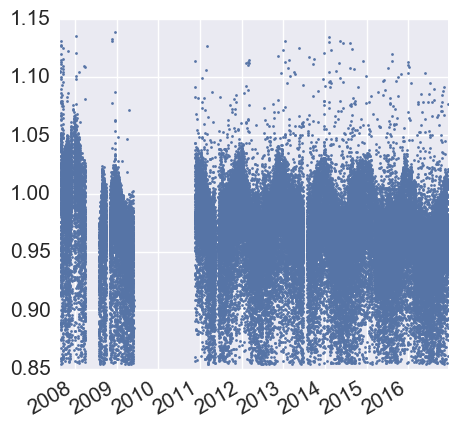

In [28]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(filtered.index, filtered, 'o', alpha = 1.0)
fig.autofmt_xdate()

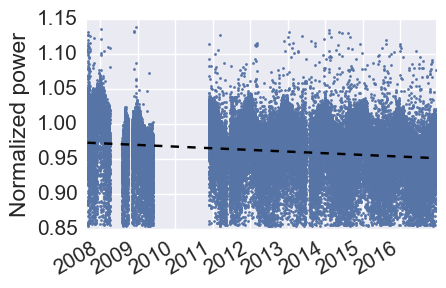

In [29]:
# plot the regression through the normalized data 
fig, ax = plt.subplots()
ax.plot(filtered.index, filtered, 'o', alpha = 1.0)
x_vals = np.array(ax.get_xlim())
y_vals = ols_info['intercept'] + ols_info['slope'] * (x_vals-min(x_vals)) / 365
ax.plot(x_vals, y_vals, '--k')

#ax.set_ylim(0,1.4)
fig.autofmt_xdate()
ax.set_ylabel('Normalized power');

In [30]:
# Plot the year-on-year distribution
# YoY_filtered1 = yoy['YoY_filtered']
# YOY_median = yoy['Rd_median']
# plt.hist(YoY_filtered1, alpha=0.5, label='YOY', bins=int(YoY_filtered1.__len__()/4))
# plt.axvline(x=YOY_median, color='black', linestyle='dashed', linewidth=3)
# #plt.legend(loc='upper right')
# plt.title('Year-on-Year 15-minute Distribution \n Data outside +/-100 removed')   
# plt.tight_layout(w_pad=1, h_pad=2.0)
# plt.xlabel('Annual degradation (%)')